# Analysis block evaluations and exit survey exp. 1

In [5]:
import os, sys

# Local modules
sys.path.append('./..')
import data_processing
import visualization
import stats

# Data management
import pandas as pd 
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.patches import Patch


### Block evaluations

##### Load data

In [8]:
# Load the config. record data saved after each trial.
subjects = data_processing.SUBJECTS_EXP1
data_dir = data_processing.DATA_DIR_EXP1
exp_filenames, clbr_filenames = data_processing.get_filenames(subjects=subjects,
                                                              data_dir=data_dir,
                                                              data_keys = ['TrialConfigRecord'])
exp_data = data_processing.load_data_from_filenames(exp_filenames)
trc_data = exp_data['TrialConfigRecord'].set_index(['Subject', 'Block', 'RelativeTrialNumber'])

# Load the block evaluations 
fn = os.path.join(data_dir,"_Exp1BlockEvaluation.csv")
block_evaluation = pd.read_csv(fn, sep=';')

##### Reformat the data

In [ ]:
# Reformat the data: in the block evaluation, a reference is stored to the corresponding trials,
# these references are aligned with the trial config. records saved by Unity after each trial.
# This is necessary to analyse the subjective responses in relation to the experimental conditions. 
block_evaluation.rename(columns={'Block Information [Subject ID]': 'Subject',
                                 'Block Information [Block ID]': 'Block',
                                }, inplace=True)
block_evaluation['Subject'] = block_evaluation.Subject.apply(lambda s: f'S{s:02d}')
block_evaluation.replace({'1st trial / condition of this block': 0,
                          '2nd trial / condition of this block': 1,
                          '3rd trial / condition of this block': 2,}, inplace=True)
block_evaluation['Block'] -=1 # Zero-start indexing (corresponds with the trial config. record data)

# For each column in the subjective evaluation, map the response to the corresponding experimental condition. 
for col in block_evaluation.columns:
    if col.startswith('Rank the conditions in order of'):
        # Map number to condition
        idx = list(block_evaluation[['Subject', 'Block', col]].itertuples(index=False, name=None))
        block_evaluation[col] = trc_data.loc[idx].GazeCondition.values

# Rename the responses (shorter answers).
rename_columns = {'Rank the conditions in order of how tiring they were, with the least tiring at the top and most tiring at the bottom. [Rank 1]': 'LeastTiring',
                  'Rank the conditions in order of how tiring they were, with the least tiring at the top and most tiring at the bottom. [Rank 3]': 'MostTiring',
                  'Rank the conditions in order of comfort, with the most comfortable at the top and least comfortable at the bottom. [Rank 1]': 'MostComfortable',
                  'Rank the conditions in order of comfort, with the most comfortable at the top and least comfortable at the bottom. [Rank 3]': 'LeastComfortable',
                  'Select all conditions that you experienced nausea or motion sickness in. [1st trial / condition of this block]': 'MotionSick0',
                  'Select all conditions that you experienced nausea or motion sickness in. [2nd trial / condition of this block]': 'MotionSick1',
                  'Select all conditions that you experienced nausea or motion sickness in. [3rd trial / condition of this block]': 'MotionSick2',
                  'Rate the conditions in regard to how well you could navigate in each of them from 1 to 5. A lower number indicates you had a harder time navigating in it.  [1st trial / condition of this block]':'Rating0',
                  'Rate the conditions in regard to how well you could navigate in each of them from 1 to 5. A lower number indicates you had a harder time navigating in it.  [2nd trial / condition of this block]':'Rating1',
                  'Rate the conditions in regard to how well you could navigate in each of them from 1 to 5. A lower number indicates you had a harder time navigating in it.  [3rd trial / condition of this block]':'Rating2'}
block_evaluation.rename(columns=rename_columns, inplace=True)

##### Analysis

In [12]:
# Create output dataframe with the right indexes.
columns = ['MostTiring', 'LeastTiring', 'MostComfortable', 'LeastComfortable']
percentages = pd.DataFrame(columns=columns, index=['SimulationFixedToGaze','GazeAssistedSampling', 'GazeIgnored'])

# Value counts -> percentages
for col in columns:
    percentages[col] = 100*block_evaluation[col].value_counts(normalize=True)

# Booleans -> percentages
for (subject, block), data in block_evaluation.groupby(['Subject', 'Block']):
    for trial in range(3):
        trc_data.loc[(subject,block, trial), 'MotionSick'] = data[f'MotionSick{trial}'].item()
        trc_data.loc[(subject,block, trial), 'SubjectiveRating'] = data[f'Rating{trial}'].item()
trc_data.replace({'No':False, 'Yes':True}, inplace=True)

# Obtain the highest scoring and the lowest scoring conditions, and express this subjective rating as a percentage.
highest = trc_data.groupby(['Subject', 'Block']).SubjectiveRating.idxmax()
lowest  = trc_data.groupby(['Subject', 'Block']).SubjectiveRating.idxmin()
percentages['HighestFunctionalRating'] = 100*trc_data.loc[highest].GazeCondition.value_counts(normalize=True)
percentages['LowestFunctionalRating'] = 100*trc_data.loc[lowest].GazeCondition.value_counts(normalize=True)

# Rename the conditions (terminology consistent with paper & clean typography)
percentages.rename(index=visualization.COND_REDEFINED, inplace=True)

# Display the results
display(percentages)
display(trc_data.replace(visualization.COND_REDEFINED).groupby('GazeCondition')[['MotionSick', 'SubjectiveRating']].mean())

,MostTiring,LeastTiring,MostComfortable,LeastComfortable,HighestFunctionalRating,LowestFunctionalRating
Gaze Locked,68.115942,14.492754,13.043478,76.811594,14.492754,68.115942
Gaze Contingent,13.043478,43.478261,47.826087,8.695652,47.826087,17.391304
Gaze Ignored,18.840580,42.028986,39.130435,14.492754,37.681159,14.492754


,MotionSick,SubjectiveRating
GazeCondition,,
Gaze Contingent,0.059701,3.579710
Gaze Ignored,0.059701,3.420290
Gaze Locked,0.268657,2.507246


## Exit survey

In [9]:
# Load the exit survey
fn = os.path.join(data_dir,"_Exp1ExitSurvey.csv")
exit_survey = pd.read_csv(fn, sep=';')

# Reformat the data 
exit_survey.rename(columns={'Subject Information [Subject ID]': 'Subject',}, inplace=True)
exit_survey.drop(columns=['Response ID', 'Date submitted', 'Last page', 'Start language', 'Seed'], inplace=True)
exit_survey.set_index('Subject', inplace=True)
questions = exit_survey.columns
question_mapping = {f'Q{i:02d}': q for i,q in enumerate(questions)}
reverse_mapping = {val:key for key,val in question_mapping.items()}
responses = exit_survey.copy()
responses.columns=question_mapping.keys()

In [10]:
question_mapping

{'Q00': 'Do you feel like you had enough training time with the simulated phosphene vision and the different conditions?  Use the comment box to add an explanation / details. ',
 'Q01': 'Do you feel like you had enough training time with the simulated phosphene vision and the different conditions?  Use the comment box to add an explanation / details.  [Comment]',
 'Q02': 'Did you feel like you were still getting better throughout the trials in interpreting the simulated phosphene vision?  Use the comment box to add an explanation / details. ',
 'Q03': 'Did you feel like you were still getting better throughout the trials in interpreting the simulated phosphene vision?  Use the comment box to add an explanation / details.  [Comment]',
 'Q04': 'Can you indicate whether you used any particular strategies to navigate? Use the comment box for any added information (e.g. only in specific conditions, specifications)  [relied on hands for specific parts (which?)]',
 'Q05': 'Can you indicate wh

### Analysis

#### Demographics (Q22-Q30)

In [11]:
demographics = responses[['Q27', 'Q30']].rename(columns={'Q27':'Age','Q30':'Height'}).astype(float).copy()
demographics.describe()

,Age,Height
count,23.000000,23.000000
mean,24.260870,173.347826
std,1.935726,8.133034
min,22.000000,162.000000
25%,23.000000,165.000000
50%,24.000000,174.000000
75%,25.000000,180.000000
max,30.000000,188.000000


Q28: What sex were you assigned at birth / what is on your birth certificate?
Q22: How used to / comfortable with using controllers are you? With a 1 being unfamiliar with controllers and 5 being controllers feeling natural to use to you.
Q23: How often have you used a virtual reality headset before? (e.g. HTC Vive, Oculus Quest, Google Cardboard, Oculus Rift, ...)
Q24: Did you ever use the HTC Vive Wands (the controllers used in the experiment before)?
Q25: Do you experience motion sickness regularly? (e.g. on the bus / train, while driving, in other VR environments, ...)


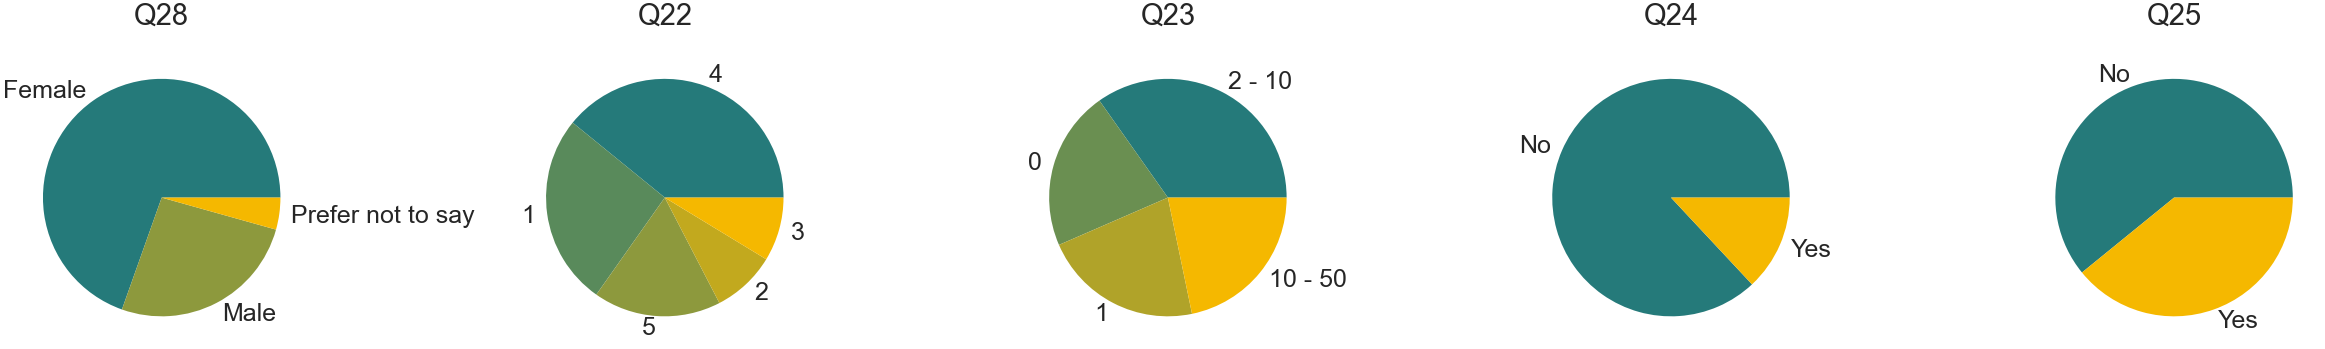

In [14]:
questions = ['Q28', 'Q22', 'Q23','Q24','Q25']

# Load color palette
visualization.set_figurestyle()
c = list(visualization.COLORS.values())

# Plot pie charts
fig, axs = plt.subplots(1,len(questions), figsize=(8,4))
for i,q in enumerate(questions):# 'Q12', 'Q13', 'Q14', 'Q12']:
    palette = sns.color_palette(f"blend:{c[1]},{c[2]}", n_colors=responses[q].nunique())
    sns.set_palette(sns.color_palette(palette))
    h = responses[q].value_counts().T.plot(kind='pie', stacked=True, ax= axs[i])
    axs[i].set(title=q, ylabel='')
    print(f'{q}: {question_mapping[q]}')
plt.tight_layout()

#### Practice / self-reported level of experience (Q7 - Q11) - Likert Scales

Q00: Do you feel like you had enough training time with the simulated phosphene vision and the different conditions?  Use the comment box to add an explanation / details. 
Q02: Did you feel like you were still getting better throughout the trials in interpreting the simulated phosphene vision?  Use the comment box to add an explanation / details. 


,Q00,Q02
Yes,95.652174,95.652174
No,4.347826,4.347826


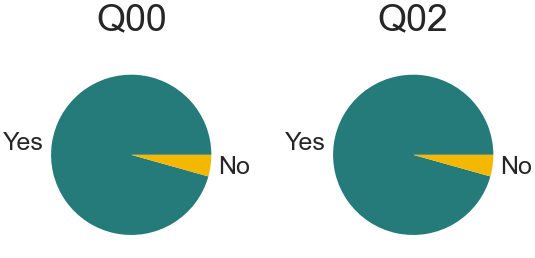

In [15]:
questions = ['Q00', 'Q02']

# Load color palette
visualization.set_figurestyle('../_figurestyle/small.mplstyle')
c = list(visualization.COLORS.values())

# Plot pycharts
fig, axs = plt.subplots(1,len(questions), figsize=(2,2))#visualization.create_subplots(len(questions), figsize=(10,10))
for i,q in enumerate(questions):# 'Q12', 'Q13', 'Q14', 'Q12']:
    palette = sns.color_palette(f"blend:{c[1]},{c[2]}", n_colors=responses[q].nunique())
    sns.set_palette(sns.color_palette(palette))
    
    h = responses[q].value_counts().T.plot(kind='pie', stacked=True, ax= axs[i])
    axs[i].set(title=q, ylabel='')
    print(f'{q}: {question_mapping[q]}')
plt.tight_layout()

display(100*responses[questions].apply(lambda col: col.value_counts(normalize=True)))

#### Strategies (Q04 - Q18)

In [16]:
strategies = responses[[f'Q{i:02d}' for i in range(4,18,2)] + ['Q20']].copy()
strategies.rename(columns = {'Q04':'Relied on hands',
                            'Q06':'exaggerated or rhythmic head movements',
                            'Q08': 'estimating depth by moving sideways',
                            'Q10': 'estimating boundaries with the center most pixels/phosphenes',
                            'Q12': 'estimating boundaries with the outer/peripheral pixels/phosphenes',
                            'Q14': 'sticking to the walls',
                            'Q16': 'moving straight-forward with as little sideway movement as possible',
                             'Q20': 'Changed strategy'
                            }, inplace=True )
100*strategies.apply(lambda col: col.value_counts(normalize=True))

,Relied on hands,exaggerated or rhythmic head movements,estimating depth by moving sideways,estimating boundaries with the center most pixels/phosphenes,estimating boundaries with the outer/peripheral pixels/phosphenes,sticking to the walls,moving straight-forward with as little sideway movement as possible,Changed strategy
No,56.521739,43.478261,60.869565,39.130435,52.173913,39.130435,43.478261,47.826087
Yes,43.478261,56.521739,39.130435,60.869565,47.826087,60.869565,56.521739,52.173913


In [17]:
comments = [f'Q{i:02d}'for i in range(5,19,2)] + ['Q21']
strategies = list(strategies) + ['Other', 'More other']
for i,c in enumerate(comments):
    print(f'{strategies[i]}:\n{responses[c].dropna().unique()}\n')

print('Other (listed): \n', responses.Q18.dropna().value_counts(normalize=True))
print(f'\n Other (free comment):\n {responses.Q19.dropna().unique()}')

Relied on hands:
['I had trouble relying on hands, but I tried to do that here and there when I got stuck behind a big block and needed to tell it apart from a wall.'
 'Touched walls around me to see if I was close or far - especially when I had a narrower space to move through'
 'just a little bit' 'feeling the distance between me and the obstacle'
 'to feel whats around me'
 'I tried doing this but found it was very time consuming and stopped by the third round.'
 'the low box that was left of me at the beginning of the trial.'
 'to figure out how close I was to an object' 'sometimes the walls'
 'outer walls']

exaggerated or rhythmic head movements:
['Apparently I moved my head more than I moved my eyes. '
 'especially with lower boxes right in front of me'
 'my periphery was very limited so I needed to move my head to see around'
 'I definitely tried to visualize the entirety of the space by moving my head a lot. '
 'to find obstacles'
 'I tried to scan the whole environment, movin